# Named Entity Recognition using Bi-LSTM

## Importing Libraries

In [1]:
# Let us import the required libraries

import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

## Loading the Dataset

In [2]:
# Let us load the dataset
data = pd.read_csv('eng-train.csv',encoding='latin1')
data = data.fillna(method = 'ffill')
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
# Now, we have to divide the dataset into lists 
# Such that one contains the words and another contains corresponding tags

words = list(set(data["Word"].values))
words.append("END")
num_words = len(words)
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [4]:
class SentanceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentances = [s for s in self.grouped]
        
getter = SentanceGetter(data)
sentances = getter.sentances

In [5]:
# Now, let us map sentences with corresponding tags

word2ind = {w: i+1 for i, w in enumerate(words)}
tag2ind = { t: i for i,t in enumerate(tags)}

In [6]:
# Let us import libraries to train the model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Padding

In [7]:
max_len = 100
X = [[word2ind[w[0]] for w in s] for s in sentances]
X = pad_sequences(maxlen = max_len, sequences =X , padding ='post',value =num_words-1)
y = [[tag2ind[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen=max_len,sequences =y,padding ='post',value=tag2ind["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [8]:
## Now, let us split the dataset into Training and Testing sets

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state =1)

## Building the Model

In [10]:
# Now, let us create the architecture

input_word = Input(shape = (max_len))
bi_lstm_model = Embedding(input_dim = num_words,output_dim = max_len,input_length  = max_len)(input_word)
bi_lstm_model = SpatialDropout1D(0.1)(bi_lstm_model)
bi_lstm_model = Bidirectional(LSTM(units = 100,return_sequences=True,recurrent_dropout = 0.1))(bi_lstm_model)
out = TimeDistributed(Dense(num_tags, activation ='softmax'))(bi_lstm_model)
bi_lstm_model = Model(input_word,out)

## Compiling the Model

In [11]:
bi_lstm_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Summary of the Model

In [12]:
bi_lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          3517900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 17)           3417      
Total params: 3,682,117
Trainable params: 3,682,117
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [14]:
training = bi_lstm_model.fit( x_train,np.array(y_train), validation_split = 0.1, batch_size = 32,epochs = 10, verbose =1)

Train on 34530 samples, validate on 3837 samples
Epoch 1/10
34530/34530 [==============================] - 575s 17ms/sample - loss: 0.1026 - accuracy: 0.9784 - val_loss: 0.0311 - val_accuracy: 0.9911
Epoch 2/10
34530/34530 [==============================] - 526s 15ms/sample - loss: 0.0247 - accuracy: 0.9927 - val_loss: 0.0246 - val_accuracy: 0.9924
Epoch 3/10
34530/34530 [==============================] - 522s 15ms/sample - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0230 - val_accuracy: 0.9928
Epoch 4/10
34530/34530 [==============================] - 526s 15ms/sample - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0236 - val_accuracy: 0.9929
Epoch 5/10
34530/34530 [==============================] - 524s 15ms/sample - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0244 - val_accuracy: 0.9930
Epoch 6/10
34530/34530 [==============================] - 521s 15ms/sample - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0253 - val_accuracy: 0.9929
Epoch 7/10
34530/34530 [=====================

## Evaluating the Model

In [15]:
bi_lstm_model.evaluate(x_test,np.array(y_test))

9592/9592 [==============================] - 38s 4ms/sample - loss: 0.0338 - accuracy: 0.9923


[0.033822384623311975, 0.99225086]

## Plots

Text(0.5, 1.0, 'Accuracy Curves')

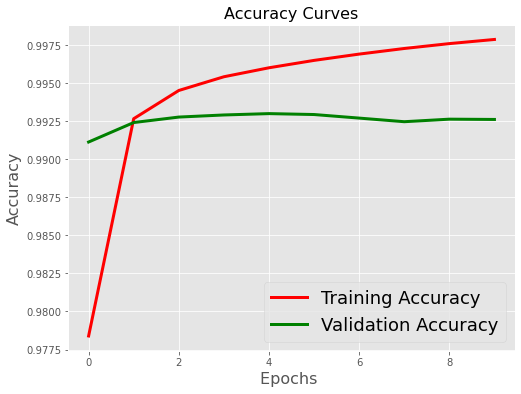

In [18]:
# Now, let us plot the Accuracy Curves

plt.figure(figsize=[8,6])
plt.plot(training.history['accuracy'],'r',linewidth=3.0)
plt.plot(training.history['val_accuracy'],'g',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
bi_lstm_model.save('')